In [13]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import shap
import joblib

In [14]:
def x_y_split(data_dir,scaler):
    data = pd.read_excel(data_dir, skiprows=0)

    data = data.astype('float64')
    x = data.iloc[:, :-3]
    x_scaled = scaler.transform(x)
    y = data.iloc[:, -3:]
    return x_scaled,y

In [15]:
data_dir = './data/train_data.xlsx'
df=pd.read_excel(data_dir, skiprows=0)
#存储表头
header = df.columns[:-3]
scaler_model_path = './model/scaler.pkl'
features, target = x_y_split(data_dir=data_dir,scaler=joblib.load(scaler_model_path))

In [16]:
print(header.shape)

(30,)


In [17]:
#查看特征形状
print(features.shape)
#查看标签形状
print(target.shape)

(16719, 30)
(16719, 3)


In [18]:
#合格要求YS ≥ 200, TS ≥ 300, EL ≥ 25。
thresholds = [200,300,25]  # 假设每列的合格阈值
is_qualified = (target> thresholds).all(axis=1).astype(int)

In [19]:
print(is_qualified.shape)

(16719,)


In [20]:
X_train=features
y_train=is_qualified
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [21]:
X_test,y_test = x_y_split(data_dir='./data/test_data.xlsx',scaler=joblib.load(scaler_model_path))
y_test=(y_test>thresholds).all(axis=1).astype(int)
# 预测并评估
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.79      0.84       220
           1       0.99      0.99      0.99      3469

    accuracy                           0.98      3689
   macro avg       0.94      0.89      0.91      3689
weighted avg       0.98      0.98      0.98      3689



In [22]:
print(clf.feature_importances_.shape)

(30,)


In [23]:
# 分析特征重要性
feature_importances = pd.DataFrame({
    'Feature': header,
    'Importance': clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("特征重要性：")
print(feature_importances)

特征重要性：
              Feature  Importance
0                   C    0.177831
2                  MN    0.157059
11          HOT_THICK    0.121626
9                  CA    0.050767
12          COL_THICK    0.047160
29          ROL_FORCE    0.043976
1                  SI    0.034043
28        CT_TEMP_AVG    0.030074
13          ACT_WIDTH    0.029566
27        FM_TEMP_AVG    0.028495
4                  NB    0.023774
23   TOP_PLATE_WT_AVG    0.023629
14       HOT_TEMP_AVG    0.022277
26           FUR_TIME    0.021351
24   BOT_PLATE_WT_AVG    0.019810
25           DIS_TEMP    0.019324
15        SW_TEMP_AVG    0.017395
22      TEN_ELONG_AVG    0.016673
18  CGL_ANN_SPEED_AVG    0.015868
6                   P    0.015182
20       TPM_RATE_AVG    0.015041
16        CS_TEMP_AVE    0.014002
8                   B    0.011138
19          BATH_TEMP    0.010218
3                   N    0.007514
7                   S    0.007027
5                  TI    0.006886
21       ANN_DIA_CODE    0.004271
17     

In [24]:
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of clf.predict_proba(X_test): {clf.predict_proba(X_test).shape}")




Shape of X_test: (3689, 30)
Shape of clf.predict_proba(X_test): (3689, 2)


In [25]:
#给X_test加上header
X_test = pd.DataFrame(X_test, columns=header)

In [26]:
#使用 SHAP 分析具体不合格样本的影响因素
explainer = shap.TreeExplainer(clf)

shap_values = explainer.shap_values(X_test)
# shap.summary_plot(shap_values, X_test, feature_names=header)



In [27]:
print(f"Shape of shap_values: {shap_values.shape}")

Shape of shap_values: (3689, 30, 2)


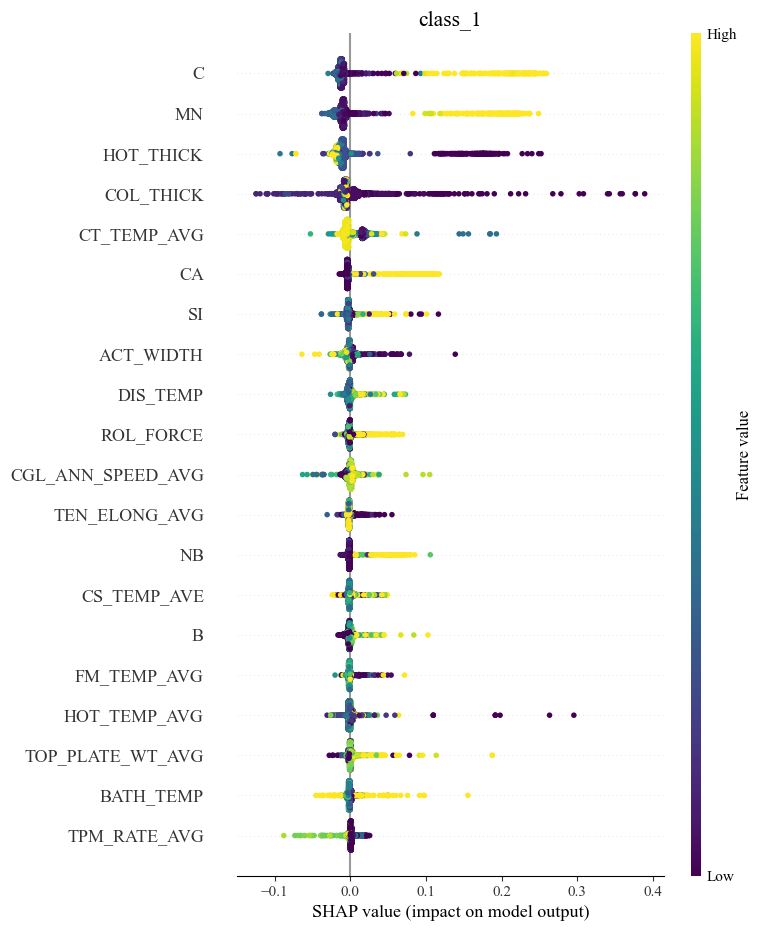

In [ ]:
import matplotlib.pyplot as plt
#特征标签
          
labels = header
          

          
# 设置 matplotlib 的全局字体配置
          
plt.rcParams['font.family'] = 'serif'
          
plt.rcParams['font.serif'] = 'Times New Roman'
          
plt.rcParams['font.size'] = 13
          

          
# 提取每个类别的 SHAP 值
          
shap_values_class_1 = shap_values[:, :, 0]
shap_values_class_2 = shap_values[:, :, 1]
          

          

          
# 绘制 SHAP 总结图，使用viridis配色方案
          
plt.figure() 
plt.title('class_1')         
shap.summary_plot(shap_values_class_1, X_test, feature_names=labels, plot_type="dot", cmap="viridis")       
plt.show()
      

(30,)
[11  0  2 12  9]
[-0.01167    -0.01024783 -0.0089017  -0.00733416 -0.00343045]
HOT_THICK    0.454545
C            0.070030
MN           0.065116
COL_THICK    0.170416
CA           0.005128
Name: 2000, dtype: float64


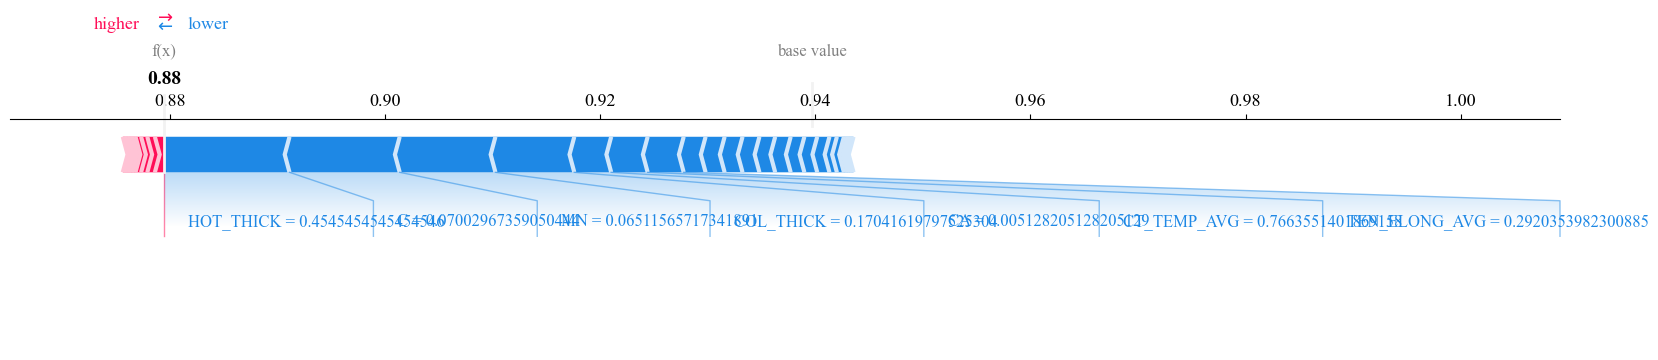

In [29]:
          
# 选择一个样本索引进行解释
          
sample_index = 2000
          
expected_value = explainer.expected_value[1]  # 需要指定个类别的基准值，这里是第一个类别
          
# 获取单个样本的 SHAP 值
          
sample_shap_values = shap_values_class_1[sample_index]
print(sample_shap_values.shape)

#找出影响最大的5个特征
top5_index = np.argsort(np.abs(sample_shap_values))[::-1][:5]
print(top5_index)
print(sample_shap_values[top5_index])
print(X_test.iloc[sample_index, top5_index])



# # 取绝对值最大的前 5 个特征
# top_indices = np.argsort(np.abs(sample_shap_values))[-5:]

# # 生成 Force Plot 只包含前 5 个特征
# shap.force_plot(expected_value, sample_shap_values[top_indices], X_test.iloc[sample_index, top_indices], matplotlib=True)




          
# 绘制 SHAP 解释力图 (Force Plot)，扩大解释力图的显示范围

shap.force_plot(expected_value, sample_shap_values, X_test.iloc[sample_index], matplotlib=True)    
          
      
# 显示绘图
          
plt.show()

In [ ]:
#将测试集的数据把一部分特征变成0，看看对结果的影响
#X_test_new为原测试集30特征分成30分，每次将一个特征变成0
length=len(X_test)
X_test_new = X_test.copy()
for i in range(30):
    #X_test_new的第i*length/30-（i+1）*length/30列的第i列变成0
    X_test_new.iloc[int(i*length/30):int((i+1)*length/30),i]=0



In [ ]:
print(X_test)

In [35]:
y_pred_new = clf.predict(X_test_new)
y_pred=clf.predict(X_test)

C:\Users\linze\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\linze\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [38]:
#查看y_pred_new和y_pred有多少不同
print(np.sum(y_pred_new!=y_pred))


#查看X_test_new和X_test通过shap查看特征影响前五个是否发生变化
shape_values_new = explainer.shap_values(X_test_new)







16
0
[ 2  0 11  8 28]
[ 0 11  2 16  6]
1
[ 2 11  0 28  1]
[ 0 11  2 16 22]
2
[14 11  0 12  3]
[ 0 11 14 12 25]
3
[12  0 13 11 28]
[ 0 12 20 28 13]
4
[ 2  0 11  4 29]
[ 2 11  4 29 23]
5
[12  0 11  2 22]
[ 0 12 11 22  2]
6
[ 0 11  2 13 28]
[ 0 11 20  2 13]
7
[ 0 12  2 11 27]
[ 0 23 27  2 11]
8
[12  0  2 11  1]
[12  0  2  1 25]
9
[11 12 19  2  0]
[ 0 11 12 18  2]
10
[11 12  0 25  2]
[ 0 11  6 12 28]
11
[ 2  0 12 18  4]
[ 2 12  4 28 24]
12
[11  2  0 25 19]
[ 0 11  2 25 13]
13
[ 2 11 28  0 12]
[ 0 11  2 28 22]
14
[12  0  2 28 22]
[12  0 11 25  2]
15
[28 29  0  2 11]
[28  0 29 11  2]
16
[11  0 12 28  9]
[ 0 11 16  2 17]
17
[ 2 11  0 12 25]
[ 0  2 11 15 12]
18
[12 11  0  2 13]
[ 0 12 11 13  9]
19
[12  0 28 11  2]
[ 0 12 13 11 28]
20
[12  2  0 11 28]
[ 0 12 11  2 22]
21
[11 12  2  0 22]
[ 0  2 12 11 13]
22
[12  0  2 11  1]
[ 0 12 11  2 16]
23
[ 0  2 28 11 25]
[ 2  0 11 28 25]
24
[ 2 28  0 11 18]
[ 2 11  0 28 18]
25
[ 0 11  2 28 13]
[ 0 11 20  2 18]
26
[ 0  2 11  4 29]
[ 2 11  4 29 12]
27
[ 0  

In [ ]:
for i in range(length):
    sample_index=i
    sample_shap_values = shap_values[:, :, y_pred[i]][sample_index]
    top5_index = np.argsort(np.abs(sample_shap_values))[::-1][:5]

    sample_shap_values_new = shape_values_new[:, :, y_pred_new[i]][sample_index]
    top5_index_new = np.argsort(np.abs(sample_shap_values_new))[::-1][:5]

    if(top5_index[0]!=top5_index_new[0] or top5_index[1]!=top5_index_new[1] or top5_index[2]!=top5_index_new[2] or top5_index[3]!=top5_index_new[3] or top5_index[4]!=top5_index_new[4]):
        print(i)
        print(top5_index)
        print(top5_index_new)
